# 3) Outlier Analysis

In [1]:
import pandas as pd

# Load the datasets
confirmed_cases_path = '/content/time_series_covid19_confirmed_US.csv'
deaths_cases_path = '/content/time_series_covid19_deaths_US.csv'
vaccinations_path = '/content/us_state_vaccinations.csv'

# Reading the datasets
confirmed_df = pd.read_csv(confirmed_cases_path)
deaths_df = pd.read_csv(deaths_cases_path)
vaccinations_df = pd.read_csv(vaccinations_path)

# Display the first few rows and the structure of each dataframe
confirmed_df.head(), confirmed_df.info(), deaths_df.head(), deaths_df.info(), vaccinations_df.head(), vaccinations_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Columns: 1154 entries, UID to 3/9/23
dtypes: float64(906), int64(242), object(6)
memory usage: 22.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Columns: 1155 entries, UID to 3/9/23
dtypes: float64(3), int64(1146), object(6)
memory usage: 29.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54628 entries, 0 to 54627
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 54628 non-null  object 
 1   location                             54628 non-null  object 
 2   total_vaccinations                   32532 non-null  float64
 3   total_distributed                    32272 non-null  float64
 4   people_vaccinated                    32268 non-null  float64
 5   people_fully_vaccinated_per_hundred  30651 non-null  float64
 6   tot

(        UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
 0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
 1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
 2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   
 3  84001007   US  USA    840  1007.0     Bibb        Alabama             US   
 4  84001009   US  USA    840  1009.0   Blount        Alabama             US   
 
          Lat      Long_  ...  2/28/23   3/1/23   3/2/23   3/3/23   3/4/23  \
 0  32.539527 -86.644082  ...  19732.0  19759.0  19759.0  19759.0  19759.0   
 1  30.727750 -87.722071  ...  69641.0  69767.0  69767.0  69767.0  69767.0   
 2  31.868263 -85.387129  ...   7451.0   7474.0   7474.0   7474.0   7474.0   
 3  32.996421 -87.125115  ...   8067.0   8087.0   8087.0   8087.0   8087.0   
 4  33.982109 -86.567906  ...  18616.0  18673.0  18673.0  18673.0  18673.0   
 
     3/5/23   3/6/23   3/7/23   3/8/23   3/9/23 

In [5]:
import matplotlib.pyplot as plt

# Convert wide format data to long format for easier manipulation and plotting
date_columns = confirmed_df.columns[11:]  # Excluding non-date columns
us_confirmed_long = confirmed_df.melt(id_vars=["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Province_State", "Country_Region", "Lat", "Long_", "Combined_Key"],
                                      value_vars=date_columns,
                                      var_name="Date",
                                      value_name="Confirmed")

# Convert 'Date' from string to datetime type
us_confirmed_long['Date'] = pd.to_datetime(us_confirmed_long['Date'])

# Group by date to get the total cases per day at the national level
us_daily_cases = us_confirmed_long.groupby('Date')['Confirmed'].sum()


# Convert date columns and melt the dataframe
date_columns = confirmed_df.columns[11:]  # adjust based on your dataframe
confirmed_long = confirmed_df.melt(id_vars=["UID", "Province_State"], value_vars=date_columns, var_name="Date", value_name="Cases")
confirmed_long['Date'] = pd.to_datetime(confirmed_long['Date'])



<ipython-input-5-358bc2ca45f1>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  us_confirmed_long['Date'] = pd.to_datetime(us_confirmed_long['Date'])
<ipython-input-5-358bc2ca45f1>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  confirmed_long['Date'] = pd.to_datetime(confirmed_long['Date'])


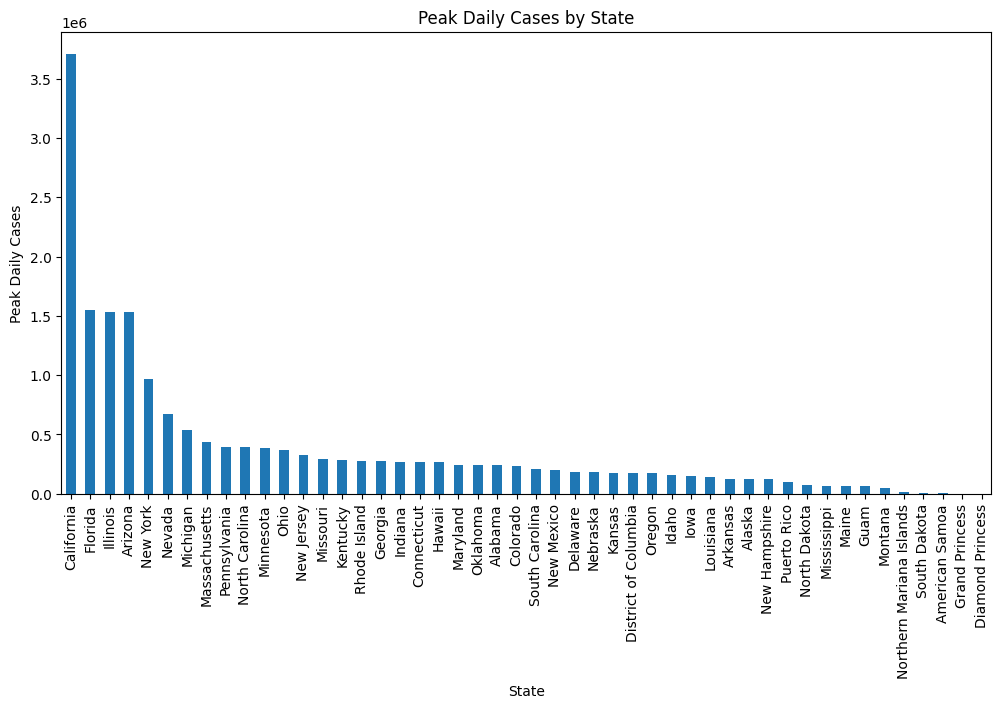

In [6]:
import matplotlib.pyplot as plt

# Finding outlier states or periods
# Example: States with the highest peak cases in a single day
peak_cases_by_state = confirmed_long.groupby('Province_State')['Cases'].max()
peak_cases_by_state.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Peak Daily Cases by State')
plt.xlabel('State')
plt.ylabel('Peak Daily Cases')
plt.show()


In [8]:
# Import necessary libraries
import pandas as pd
import plotly.express as px
import numpy as np


# Convert data to long format
date_columns = confirmed_df.columns[11:]  # adjust based on your dataframe structure
confirmed_long = confirmed_df.melt(id_vars=["UID", "Province_State", "Admin2"], value_vars=date_columns, var_name="Date", value_name="Cases")
confirmed_long['Date'] = pd.to_datetime(confirmed_long['Date'])

# Aggregate data by state and date
statewise_daily_cases = confirmed_long.groupby(['Date', 'Province_State']).sum().reset_index()

# Calculate the 7-day rolling average of cases for each state
statewise_daily_cases['7-Day Average'] = statewise_daily_cases.groupby('Province_State')['Cases'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Compute the daily national average
national_daily_average = statewise_daily_cases.groupby('Date')['Cases'].mean().reset_index()
national_daily_average.rename(columns={'Cases': 'National Daily Average'}, inplace=True)

# Merge state data with national averages
statewise_daily_cases = statewise_daily_cases.merge(national_daily_average, on='Date')

# Calculate the deviation of state's daily cases from the national average
statewise_daily_cases['Deviation From National Average'] = statewise_daily_cases['7-Day Average'] - statewise_daily_cases['National Daily Average']

# Identify states with the highest and lowest average deviations
outliers = statewise_daily_cases.groupby('Province_State')['Deviation From National Average'].mean().sort_values()


<ipython-input-8-56a558a5d940>:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [9]:

# Plotting the deviations using Plotly for interactive visualization
fig = px.bar(outliers, title="Average Deviation of COVID-19 Cases from National Average by State", labels={'value': 'Average Deviation from National Daily Cases', 'Province_State': 'State'})
fig.show()

# Highlighting specific outliers - states with the greatest positive and negative deviations
print("Top 5 Outlier States with Positive Deviation:")
print(outliers.tail(5))
print("\nTop 5 Outlier States with Negative Deviation:")
print(outliers.head(5))


Top 5 Outlier States with Positive Deviation:
Province_State
Pennsylvania    8.044911e+05
Illinois        1.052733e+06
New York        2.156509e+06
Florida         2.667449e+06
California      4.569633e+06
Name: Deviation From National Average, dtype: float64

Top 5 Outlier States with Negative Deviation:
Province_State
Diamond Princess           -793251.130523
Grand Princess             -793200.594215
American Samoa             -791037.029035
Northern Mariana Islands   -788824.941546
South Dakota               -783011.558719
Name: Deviation From National Average, dtype: float64


In [12]:
# Import necessary libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


# Convert data to long format
date_columns = confirmed_df.columns[11:]  # Adjust based on your dataframe
confirmed_long = confirmed_df.melt(id_vars=["UID", "Province_State", "Admin2"], value_vars=date_columns, var_name="Date", value_name="Cases")
confirmed_long['Date'] = pd.to_datetime(confirmed_long['Date'])

# Aggregate data by state and date
statewise_daily_cases = confirmed_long.groupby(['Date', 'Province_State']).sum().reset_index()

# Calculate the 7-day rolling average of cases for each state
statewise_daily_cases['7-Day Average'] = statewise_daily_cases.groupby('Province_State')['Cases'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


<ipython-input-12-55e156711b21>:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [13]:

# Box plot to visualize the distribution of 7-day averages by state
fig_box = px.box(statewise_daily_cases, x='Province_State', y='7-Day Average', title="Distribution of 7-Day Average COVID-19 Cases by State")
fig_box.update_traces(quartilemethod="inclusive")  # Can be 'inclusive' or 'exclusive'
fig_box.update_layout(xaxis_title="State", yaxis_title="7-Day Average Cases", xaxis={'categoryorder':'total descending'})
fig_box.show()




In [11]:
# Interactive scatter plot to visualize daily cases with a trend line
fig_scatter = px.scatter(statewise_daily_cases, x='Date', y='7-Day Average', color='Province_State', title="Trend of 7-Day Average COVID-19 Cases by State")
fig_scatter.update_traces(mode='lines+markers')
fig_scatter.update_layout(xaxis_title="Date", yaxis_title="7-Day Average Cases")
fig_scatter.show()